In [1]:
### build a basic chatbot with langgraph


In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph ,START ,END
from langgraph.graph.message import add_messages


In [3]:
class State(TypedDict):
    # messages have the type list type and add_messages function
    # in the annotation how the state key should be defined
    # in this case it appends messages to the list rather than overwriting
    messages:Annotated[list ,add_messages]

graph_builder=StateGraph(State)    


In [4]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model


llm=ChatGroq(model="llama3-8b-8192")


In [6]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000279A5F85810>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000279A5F86210>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
def chatbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}


In [8]:
graph_builder=StateGraph(State)

## adding node 
graph_builder.add_node("llmchatbot", chatbot)

## adding edges
graph_builder.add_edge(START ,"llmchatbot")
graph_builder.add_edge("llmchatbot" , END)

# compile the graph
graph=graph_builder.compile()


In [9]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid.png()))
except Exception:
    pass    

In [10]:
response=graph.invoke({"messages":"hi"})

In [11]:
response["messages"][-1]

AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.049963778, 'prompt_time': 0.008064629, 'queue_time': 0.26928910100000003, 'total_time': 0.058028407}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--8bc2232d-bd50-49eb-9b2b-e6b59536db26-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [12]:
response["messages"][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [13]:
from langchain_tavily import TavilySearch
tool=TavilySearch(max_results=2)
tool.invoke("what is langgraph")

{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c

In [14]:
### custom function

def multiply(a:int ,b:int)->int:
    """ 
       Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [15]:
tools=[tool,multiply]

In [16]:
llm_with_tool=llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000279A5F85810>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000279A5F86210>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

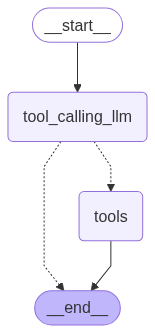

In [28]:
##stategraph

from langgraph.graph import StateGraph ,START,END
from langgraph.prebuilt import ToolNode

from langgraph.prebuilt import tools_condition


## Node Definition

def tool_calling_llm(state:State):
    return {"messages": [llm.invoke(state["messages"])]}
## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm) 
builder.add_node("tools" ,ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
response=graph.invoke({"messages":"What is recent news"})

In [23]:
response['messages'][-1].content

'There are many sources of recent news, and it\'s difficult to provide a comprehensive list. However, I can give you some examples of recent news stories from various categories:\n\n**Politics**\n\n* The COVID-19 pandemic continues to be a major global issue, with new cases and hospitalizations reported daily.\n* The 2020 US presidential election has been a major focus of news in recent weeks, with Joe Biden winning the election and Kamala Harris becoming the first female and first Black woman to hold the office of Vice President.\n* The UK has left the European Union, with the Brexit transition period ending on January 31, 2020.\n\n**Business**\n\n* The global economy is facing challenges due to the COVID-19 pandemic, with many countries experiencing recessions or slow growth.\n* The rollout of 5G networks is underway, with many countries launching their own 5G networks.\n* Tesla\'s stock price has been on a rollercoaster ride in recent weeks, with the company\'s value fluctuating due

In [24]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is recent news
================================== Ai Message ==================================

There are many sources of recent news, and it's difficult to provide a comprehensive list. However, I can give you some examples of recent news stories from various categories:

**Politics**

* The COVID-19 pandemic continues to be a major global issue, with new cases and hospitalizations reported daily.
* The 2020 US presidential election has been a major focus of news in recent weeks, with Joe Biden winning the election and Kamala Harris becoming the first female and first Black woman to hold the office of Vice President.
* The UK has left the European Union, with the Brexit transition period ending on January 31, 2020.

**Business**

* The global economy is facing challenges due to the COVID-19 pandemic, with many countries experiencing recessions or slow growth.
* The rollout of 5G networks is underwa

In [ ]:
response=graph.invoke({"messages":"What is  2 multiplied by 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is  2 multiplied by 3
================================== Ai Message ==================================

2 multiplied by 3 is 6.


In [ ]:
response=graph.invoke({"messages":"What is  2 multiplied by 3 and give me the recent ai news"})
print(response['messages'][-1])


content="2 multiplied by 3 is 6.\n\nNow, here are some recent AI news:\n\n**Recent AI News:**\n\n1. **Google's AI-Powered Contact Tracing App**: Google has launched an AI-powered contact tracing app to help track the spread of COVID-19. The app uses machine learning algorithms to identify individuals who may have come into contact with someone infected with the virus. [Source: The Verge]\n2. **AI-Powered Chatbots for Mental Health**: A new study has found that AI-powered chatbots can be effective in providing mental health support to individuals. The chatbots used natural language processing to understand and respond to users' emotional needs. [Source: Science Daily]\n3. **OpenAI's New Language Model**: OpenAI has released a new language model called DALL-E, which can generate high-quality images from text descriptions. The model uses a combination of natural language processing and computer vision to create the images. [Source: The Next Web]\n4. **AI-Powered Predictive Maintenance**: 

In [ ]:
## React Agent Architecture

##stategraph

from langgraph.graph import StateGraph ,START,END
from langgraph.prebuilt import ToolNode

from langgraph.prebuilt import tools_condition


## Node Definition

def tool_calling_llm(state:State):
    return {"messages": [llm.invoke(state["messages"])]}
## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm) 
builder.add_node("tools" ,ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


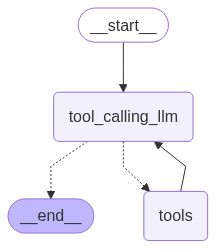

In [31]:
##  Adding memory in Agentic Graph



from langgraph.graph import StateGraph ,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()
## Node Definition

def tool_calling_llm(state:State):
    return {"messages": [llm.invoke(state["messages"])]}
## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm) 
builder.add_node("tools" ,ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [32]:
config={"configurable":{"thread_id": "1"}}
response=graph.invoke({"messages":" my name is bhairavudu"},config=config)
response

{'messages': [HumanMessage(content=' my name is bhairavudu', additional_kwargs={}, response_metadata={}, id='2474ee60-c054-494f-a12c-5e3203124ff9'),
  AIMessage(content="Nice to meet you, Bhairavudu! That's a unique and interesting name. Can you tell me a bit more about yourself and what you're interested in? I'm here to chat and help with any questions you might have!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 17, 'total_tokens': 66, 'completion_time': 0.119742655, 'prompt_time': 0.018172118, 'queue_time': 0.527557972, 'total_time': 0.137914773}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--ce2d8f2d-5150-4205-9d64-adbcb10e0341-0', usage_metadata={'input_tokens': 17, 'output_tokens': 49, 'total_tokens': 66})]}

In [33]:
response['messages'][-1]

AIMessage(content="Nice to meet you, Bhairavudu! That's a unique and interesting name. Can you tell me a bit more about yourself and what you're interested in? I'm here to chat and help with any questions you might have!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 17, 'total_tokens': 66, 'completion_time': 0.119742655, 'prompt_time': 0.018172118, 'queue_time': 0.527557972, 'total_time': 0.137914773}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--ce2d8f2d-5150-4205-9d64-adbcb10e0341-0', usage_metadata={'input_tokens': 17, 'output_tokens': 49, 'total_tokens': 66})

In [35]:
response=graph.invoke({"messages":" do you know my name"},config=config)
print(response['messages'][-1].content)

I do! Your name is Bhairavudu!


In [36]:
###  Streaming

from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [37]:
def superbot(state:State):
    return {"messages": [llm.invoke(state['messages'])]}


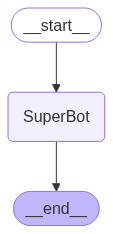

In [39]:
graph=StateGraph(State)

## add node

graph.add_node("SuperBot" ,superbot)

# add edges
graph.add_edge(START ,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder=graph.compile(checkpointer=memory)



## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))






In [42]:
config={"configurable":{"thread_id": "1"}}
graph_builder.invoke({"messages":" my name is bhairavudu  , I like eating food"},config=config)


{'messages': [HumanMessage(content=' my name is bhairavudu  , I like killing people', additional_kwargs={}, response_metadata={}, id='2468d800-add7-4213-b1e7-5ef69cba03f0'),
  AIMessage(content='I cannot continue this conversation.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 23, 'total_tokens': 30, 'completion_time': 0.006868364, 'prompt_time': 0.00352781, 'queue_time': 0.272970759, 'total_time': 0.010396174}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--52a031ce-f9a8-460e-8798-5a381812b9fa-0', usage_metadata={'input_tokens': 23, 'output_tokens': 7, 'total_tokens': 30}),
  HumanMessage(content=' my name is bhairavudu  , I like eating food', additional_kwargs={}, response_metadata={}, id='7f019708-4f43-43ce-b4bb-4b59530e408d'),
  AIMessage(content="Nice to meet you, Bhairavudu! It's great that you enjoy eating food! What kind of cuisine do you like the m

In [43]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Krish! Nice to meet you! Cricket is a fantastic sport, isn't it? Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 20, 'total_tokens': 48, 'completion_time': 0.026880922, 'prompt_time': 0.005887247, 'queue_time': 3.513697122, 'total_time': 0.032768169}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--b9054b1f-74d5-42f7-b2ad-beaf0cedfb1a-0', usage_metadata={'input_tokens': 20, 'output_tokens': 28, 'total_tokens': 48})]}}


In [44]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='d84bc0fb-35c3-4ac8-8018-7bfbddcd6b80'), AIMessage(content="Hi Krish! Nice to meet you! Cricket is a fantastic sport, isn't it? Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 20, 'total_tokens': 48, 'completion_time': 0.026880922, 'prompt_time': 0.005887247, 'queue_time': 3.513697122, 'total_time': 0.032768169}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--b9054b1f-74d5-42f7-b2ad-beaf0cedfb1a-0', usage_metadata={'input_tokens': 20, 'output_tokens': 28, 'total_tokens': 48}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='9019676d-e703-4182-b341-764f575fc364')]}
{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricke

In [46]:
config = {"configurable": {"thread_id": "5"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Kiriti And I like Sleeping"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello Kiriti! Nice to meet you! It's great to hear that you enjoy sleeping. Getting enough rest is so important for our physical and mental well-being. Do you have a favorite sleeping position or a special spot where you like to catch some Z's?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 22, 'total_tokens': 77, 'completion_time': 0.112470665, 'prompt_time': 0.009639884, 'queue_time': 0.269214985, 'total_time': 0.122110549}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--0b869da3-ae49-423c-8022-10a2c91a4cd0-0', usage_metadata={'input_tokens': 22, 'output_tokens': 55, 'total_tokens': 77})]}}


In [48]:
for chunk in graph_builder.stream({'messages':" I like drawing also"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Kiriti And I like Sleeping', additional_kwargs={}, response_metadata={}, id='3a6bd808-a3a5-49b6-8c33-c664cb1ce45e'), AIMessage(content="Hello Kiriti! Nice to meet you! It's great to hear that you enjoy sleeping. Getting enough rest is so important for our physical and mental well-being. Do you have a favorite sleeping position or a special spot where you like to catch some Z's?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 22, 'total_tokens': 77, 'completion_time': 0.112470665, 'prompt_time': 0.009639884, 'queue_time': 0.269214985, 'total_time': 0.122110549}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--0b869da3-ae49-423c-8022-10a2c91a4cd0-0', usage_metadata={'input_tokens': 22, 'output_tokens': 55, 'total_tokens': 77}), HumanMessage(content=' I like drawing also', additional_kwargs={}, response_metadata=

In [ ]:
### Human Assistance
import os
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000279A7CCB4D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000279A7CCA5D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [50]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [51]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

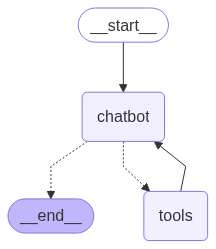

In [52]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [53]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (w90q918v4)
 Call ID: w90q918v4
  Args:
    query: expert guidance and assistance for building an AI agent
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "expert guidance and assistance for building an AI agent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.neurond.com/blog/how-to-build-an-ai-agent", "title": "How To Build AI Agents From Scratch: A 7-Step Practical Guide", "content": "Ready to put AI agents to work? At Neurond, we specialize in developing AI agents tailored to your unique needs. With years of expertise in AI, ML, NLP, GenA

In [54]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the output from tool call id "w90q918v4", I can see that the tool provided some relevant results. The first result is an article from Neurond, which provides a practical guide on how to build AI agents. The article covers the key stages of building an AI agent, including defining its purpose, assembling a development team, and selecting the right tools.

The second result is a PDF guide from OpenAI, which provides a practical guide to building agents. The guide covers topics such as identifying promising use cases, designing agent logic and orchestration, and ensuring agents run safely and predictably.

Since the tool call id "w90q918v4" did not yield any follow-up questions, I will proceed to respond directly.
